In [ ]:
# TensorFlow's Keras API for image data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Matplotlib and Seaborn for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NumPy for numerical operations
import numpy as np

# Random for generating random numbers
import random

# TensorFlow for machine learning operations
import tensorflow as tf

# Keras Model and layers for building the U-Net architecture
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate

# Regularizers and Optimizers for the model
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam

# Callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):
    """
    Generate data batches for image segmentation tasks.

    Args:
        data_dir (str): The directory containing the dataset with subdirectories for train, validation, and test sets.
        batch_size (int): The batch size to use for the data generators.
        target_size (tuple): The target size to resize the images and masks, specified as (height, width).
        seed (int or None, optional): Random seed for reproducibility. Defaults to None.
        train_augmentation (bool, optional): Flag to enable data augmentation for the training set. Defaults to False.

    Returns:
        tuple: A tuple containing the following data generators:
            - train_images_generator (DirectoryIterator): Data generator for training set images.
            - train_masks_generator (DirectoryIterator): Data generator for training set masks.
            - valid_images_generator (DirectoryIterator): Data generator for validation set images.
            - valid_masks_generator (DirectoryIterator): Data generator for validation set masks.
            - test_images_generator (DirectoryIterator): Data generator for test set images.
            - test_masks_generator (DirectoryIterator): Data generator for test set masks.
    """

    # Rescaling factor for all sets
    rescale_factor = 1.0 / 255.0

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Data augmentation for the training set
    if train_augmentation:
        train_data_generator = ImageDataGenerator(
            rescale=rescale_factor,
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.7, 1.3],
            fill_mode='reflect',
        )
    else:
        train_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Data generators for validation and test sets (without augmentation)
    valid_data_generator = ImageDataGenerator(rescale=rescale_factor)
    test_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Flow data from directories and apply augmentation where applicable
    train_images_generator = train_data_generator.flow_from_directory(
        data_dir + '/train/images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        #color_mode = 'grayscale',
        shuffle=True, #shuffle to introduce randomness for better better generalization
        seed=seed
    )

    train_masks_generator = train_data_generator.flow_from_directory(
        data_dir + '/train/masks',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=True, #shuffle to introduce randomness for better better generalization
        seed=seed
    )

    valid_images_generator = valid_data_generator.flow_from_directory(
        data_dir + '/valid/images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        #color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper evaluation of the model's performance
        seed=seed
    )

    valid_masks_generator = valid_data_generator.flow_from_directory(
        data_dir + '/valid/masks',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper evaluation of the model's performance
        seed=seed
    )

    test_images_generator = test_data_generator.flow_from_directory(
        data_dir + '/test/images',
        target_size=target_size,
        batch_size=100, # set test batch size = full test sample size
        class_mode=None,
        #color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper prediction of the model's performance
        seed=seed
    )

    test_masks_generator = test_data_generator.flow_from_directory(
        data_dir + '/test/masks',
        target_size=target_size,
        batch_size=100, # set test batch size = full test sample size
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=False, # unshuffle to maintain its original order for proper prediction of the model's performance
        seed=seed
    )

    return (
        train_images_generator, train_masks_generator,
        valid_images_generator, valid_masks_generator,
        test_images_generator, test_masks_generator
    )

In [ ]:
# Set parameters for `generate_data_batches` functon
data_dir = './new_data/'
batch_size = 16
seed = 123
target_size = (256, 256)

# Generate the data batches using the specified parameters
(train_images_gen, train_masks_gen,
 validation_images_gen, validation_masks_gen,
 test_images_gen, test_masks_gen) = generate_data_batches(
    data_dir,
    batch_size,
    target_size=target_size,
    seed=seed,
    train_augmentation=True
)

# Pack train generator as `(x, y)` and validation genereators as `(x_val, y_val)`
train_generator = zip(train_images_gen, train_masks_gen)
val_generator = zip(validation_images_gen, validation_masks_gen)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


<a name="inspect-genereated-batches"></a>
### Inspect Genereated Batches

In [ ]:
# Get the number of samples in the train images
train_samples = train_images_gen.samples

# Get the batch size
batch_size = train_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Images")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Images
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


In [ ]:
# Get the number of samples in the train masks
train_samples = train_masks_gen.samples

# Get the batch size
batch_size = train_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Masks")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Masks
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


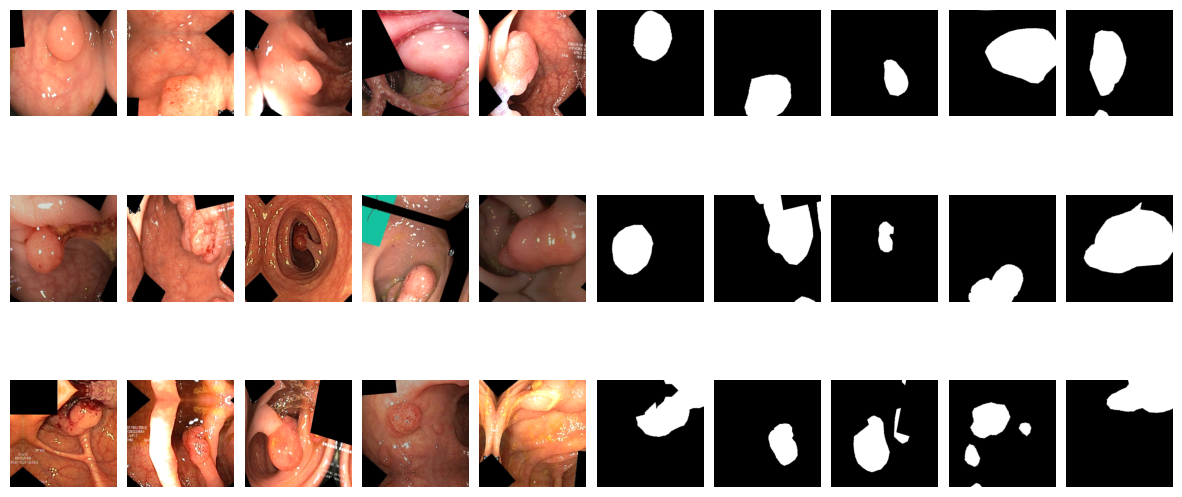

In [ ]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = train_images_gen.next()[:images_per_batch]
    batch_masks = train_masks_gen.next()[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
print("Minimum train image pixel value:", batch_images[0].min())
print("Maximum train image pixel value:", batch_images[0].max())
print("Minimum train mask pixel value:", batch_masks[0].min())
print("Maximum train mask pixel value:", batch_masks[0].max())

Minimum train image pixel value: 0.0
Maximum train image pixel value: 1.0
Minimum train mask pixel value: 0.0
Maximum train mask pixel value: 1.0


<a name="validation-batches"></a>
#### Validation batches

In [ ]:
# Get the number of samples in the validation images
validation_samples = validation_images_gen.samples

# Get the batch size
batch_size = validation_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Validation Images")
print("Number of samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of batches (validation steps):", round(validation_steps))

Validation Images
Number of samples: 100
Batch size: 16
Number of batches (validation steps): 6


In [ ]:
# Get the number of samples in the validation masks
validation_samples = validation_masks_gen.samples

# Get the batch size
batch_size = validation_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Validation Masks")
print("Number of validation samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of validation batches (validation steps):", round(validation_steps))

Validation Masks
Number of validation samples: 100
Batch size: 16
Number of validation batches (validation steps): 6


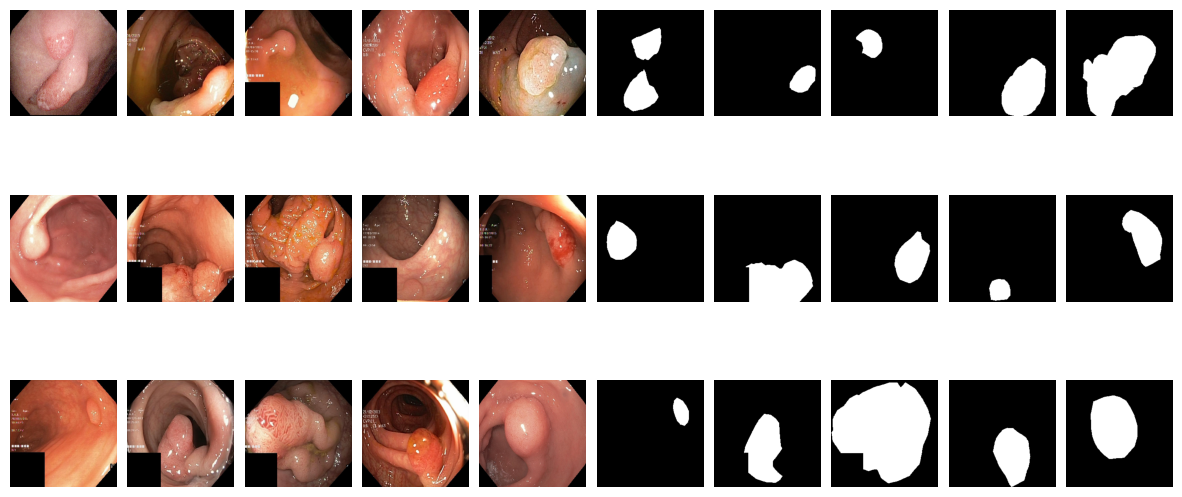

In [ ]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = validation_images_gen.next()[:images_per_batch]
    batch_masks = validation_masks_gen.next()[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
print("Minimum validation image pixel value:", batch_images[0].min())
print("Maximum validation image pixel value:", batch_images[0].max())
print("Minimum validation mask pixel value:", batch_masks[0].min())
print("Maximum validation mask pixel value:", batch_masks[0].max())

Minimum validation image pixel value: 0.0
Maximum validation image pixel value: 1.0
Minimum validation mask pixel value: 0.0
Maximum validation mask pixel value: 1.0


<a name="test-batch"></a>
#### Test batch

In [ ]:
test_images_gen.batch_size

100

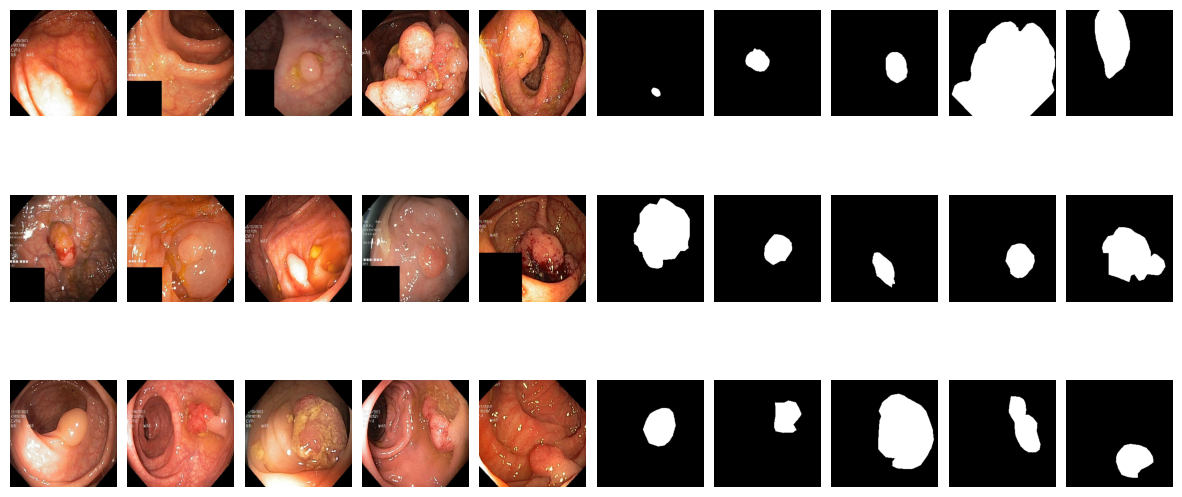

In [ ]:
# Set the number of rows and columns for the grid
num_rows = 3
num_cols = 5
total_images = num_rows * num_cols # total of 15 images to display

# Plot the images and masks in a grid
fig, axes = plt.subplots(num_rows, 2 * num_cols, figsize=(15, 7))

# Get the test batch
test_batch_images = test_images_gen.next()
test_batch_masks = test_masks_gen.next()

# Iterate over the images in the test batch and plot them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Plot the image
        axes[i, j].imshow(test_batch_images[index], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + num_cols].imshow(test_batch_masks[index], cmap='gray')
        axes[i, j + num_cols].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
print("Minimum test image pixel value:", batch_images[0].min())
print("Maximum test image pixel value:", batch_images[0].max())
print("Minimum test mask pixel value:", batch_masks[0].min())
print("Maximum test mask pixel value:", batch_masks[0].max())

Minimum test image pixel value: 0.0
Maximum test image pixel value: 1.0
Minimum test mask pixel value: 0.0
Maximum test mask pixel value: 1.0


<a name="model-architercture"></a>
### Model architercture
The U-Net architecture can be visualized as a "U" shape, which gives it its name. Here's a breakdown of its structure:

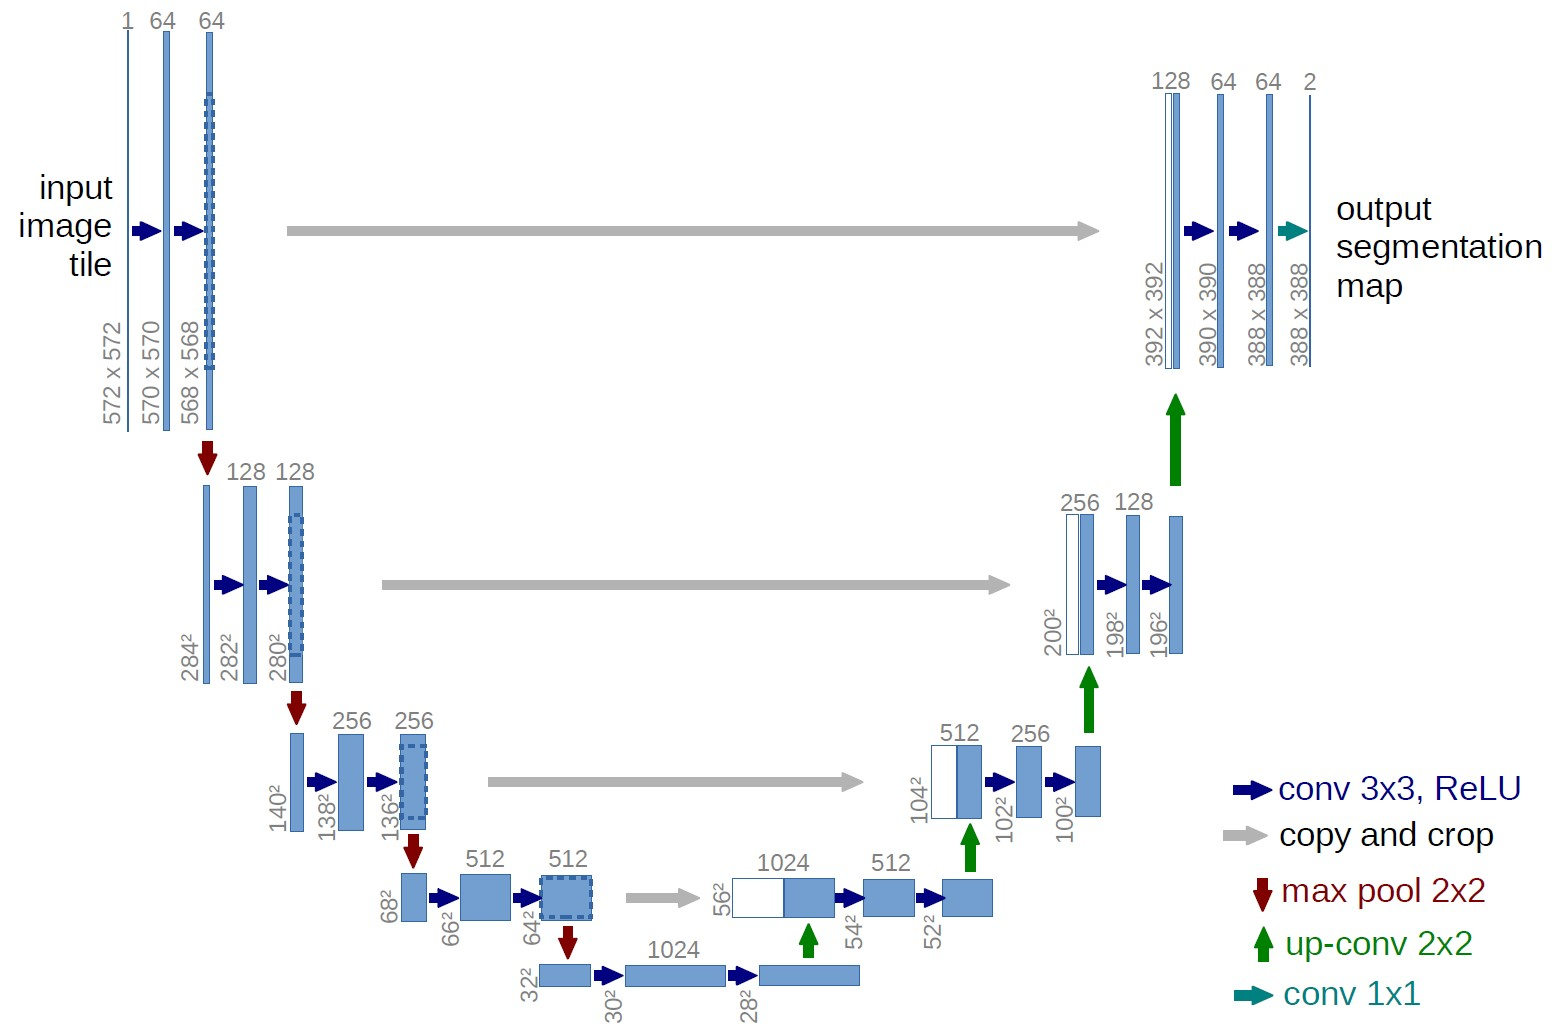

1. **Encoder (Downsampling Path):** The encoder captures the context in the image. It consists of a series of convolutional layers, batch normalization layers, activation functions (usually ReLU), and max-pooling layers. Each step down the U consists of two convolutions followed by a max-pooling operation to reduce the dimensions of the feature maps. This helps the network learn increasingly abstract features.

2. **Decoder (Upsampling Path):** The decoder enables precise localization using transposed convolutions. It consists of a series of up-convolutional layers (or transposed convolutions), concatenation with feature maps from the encoder (skip connections), followed by regular convolutions. The transposed convolutions increase the dimensions of the feature maps.

3. **Skip Connections:** These are the "bridges" between the encoder and decoder. They help the decoder recover the spatial information lost during encoding, which is crucial for achieving precise segmentation.

4. **Bottleneck:** This is the deepest layer in the U-Net, connecting the encoder and decoder. It usually consists of convolutions and activation functions but no pooling. This layer is responsible for the most abstract feature representations.

5. **Output Layer:** The final layer is a 1x1 convolution followed by an activation function like sigmoid (for binary segmentation) or softmax (for multi-class segmentation).

In [ ]:
# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
def conv_block(input, num_filters):
    """
    Create a block of two convolutional layers each followed by batch normalization and ReLU activation.

    Args:
        input (Tensor): Input tensor.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        x (Tensor): Output tensor after applying two convolutional layers, batch normalization, and ReLU activation.
    """

    # First convolutional layer
    x = Conv2D(num_filters, 3,
               #kernel_initializer='he_uniform',
               kernel_regularizer=l2(1e-5),
               padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    # Second convolutional layer
    x = Conv2D(num_filters, 3,
               #kernel_initializer='he_uniform',
               kernel_regularizer=l2(1e-5),
               padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    # Adding Dropout after the activation
    #x = Dropout(0.25)(x)
    return x

def encoder_block(input, num_filters):
    """
    Create an encoder block with a convolutional block followed by max-pooling.

    Args:
        input (Tensor): Input tensor.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        x (Tensor): Output tensor after the convolutional block.
        p (Tensor): Output tensor after max-pooling.
    """

    # Convolutional block
    # The conv output can be used for concatenation (skip connections) with decoder
    x = conv_block(input, num_filters)

    # Max-pooling
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    """
    Create a decoder block with a transposed convolutional layer and a convolutional block.

    Args:
        input (Tensor): Input tensor.
        skip_features (Tensor): Tensor from the encoder to be concatenated with the input.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        x (Tensor): Output tensor after the decoder block.
    """

    # Transposed convolutional layer
    x = Conv2DTranspose(num_filters, (2, 2),
                        strides=2,
                        #kernel_initializer='he_uniform',
                        kernel_regularizer=l2(1e-5),
                        padding="same")(input)

    # Concatenation with skip connection features
    x = Concatenate()([x, skip_features])

     # Convolutional block
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
     """
    Build a U-Net model for image segmentation.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        n_classes (int): Number of classes for segmentation.

    Returns:
        model (Model): U-Net model.
    """
    inputs = Input(input_shape)

    # Encoder blocks
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder blocks
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer: choose activation function based on the number of classes
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4) #Change the activation based on n_classes
    print(f"Output activation: {activation}")

    model = Model(inputs, outputs, name="U-Net")
    return model

<a name="model-configuration"></a>
### Model configuration

In [ ]:
# Get the shape of the input images
x = train_images_gen.__next__()
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Number of classes (binary segmentation)
n_classes = 1

In [ ]:
# sanity check
x.shape[0] #batch size

16

In [ ]:
# sanity check
input_shape #input shape

(256, 256, 3)

In [ ]:
# sanity check
y = train_masks_gen.__next__()
y.shape[1:] #target shape

(256, 256, 1)

In [ ]:
# Define Dice coefficient for evaluating segmentation performance
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

# Define Dice loss based on Dice coefficient
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

# Define IoU (Intersection over Union) coefficient
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Define IoU loss based on IoU coefficient
def iou_loss(y_true, y_pred):
    loss = 1 - iou_coefficient(y_true, y_pred)
    return loss

# Learning rate
lr = 1e-4

In [ ]:
# Build and compile the U-Net model
model = build_unet(input_shape, n_classes=n_classes)

# Compile the model with different loss functions and optimizers
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=['accuracy'])
#model.compile(optimizer=Adam(lr), loss=iou_loss, metrics=['accuracy'])
#model.compile(optimizer=Nadam(lr), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Nadam(lr), loss=dice_loss, metrics=['accuracy'])
#model.compile(optimizer=Nadam(lr), loss=iou_loss, metrics=['accuracy'])

# Display the model's architecture
model.summary()

Output activation: sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                  

After experimenting with different loss functions and optimizers, the best combination that gives us the best model performance for our task is the Adam optimzer with Binary Crossentropy loss function.

In [ ]:
# Set parameters for training
epochs = 120
steps_per_epoch = train_images_gen.samples // train_images_gen.batch_size
validation_steps = validation_images_gen.samples // validation_images_gen.batch_size

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
checkpoint_path = './model/unet.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)

# Fit the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.7323
Epoch 1: val_loss improved from inf to 0.71582, saving model to ./model/unet_checkpointv2b_7a1.h5
50/50 [==============================] - 415s 8s/step - loss: 0.5864 - accuracy: 0.7323 - val_loss: 0.7158 - val_accuracy: 0.8163 - lr: 1.0000e-04
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8384
Epoch 2: val_loss improved from 0.71582 to 0.61529, saving model to ./model/unet_checkpointv2b_7a1.h5
50/50 [==============================] - 23s 467ms/step - loss: 0.4382 - accuracy: 0.8384 - val_loss: 0.6153 - val_accuracy: 0.8249 - lr: 1.0000e-04
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8340
Epoch 3: val_loss improved from 0.61529 to 0.60653, saving model to ./model/unet_checkpointv2b_7a1.h5
50/50 [==============================] - 23s 467ms/step - loss: 0.4147 - accuracy: 0.8340 - val_loss: 0.6065 - val_ac

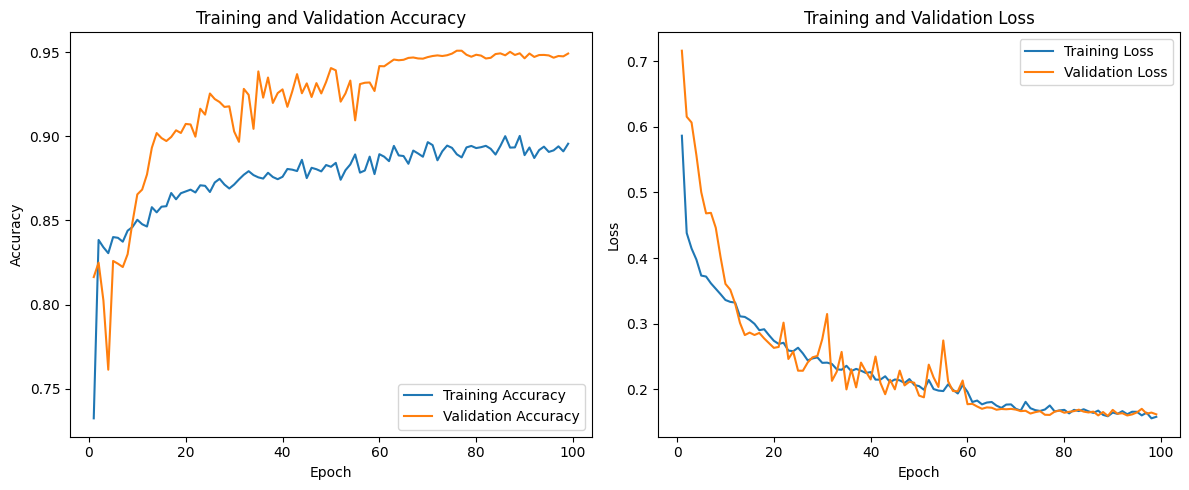

In [ ]:
# Get the history of accuracy and loss from the `history` object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the saved model
saved_model_path = './model/unet.h5'
loaded_model = tf.keras.models.load_model(saved_model_path)

<a name="confusion-matrix"></a>
### Confusion matrix

4/4 [==============================] - 5s 97ms/step
[[5361958   89861]
 [ 222039  879742]]


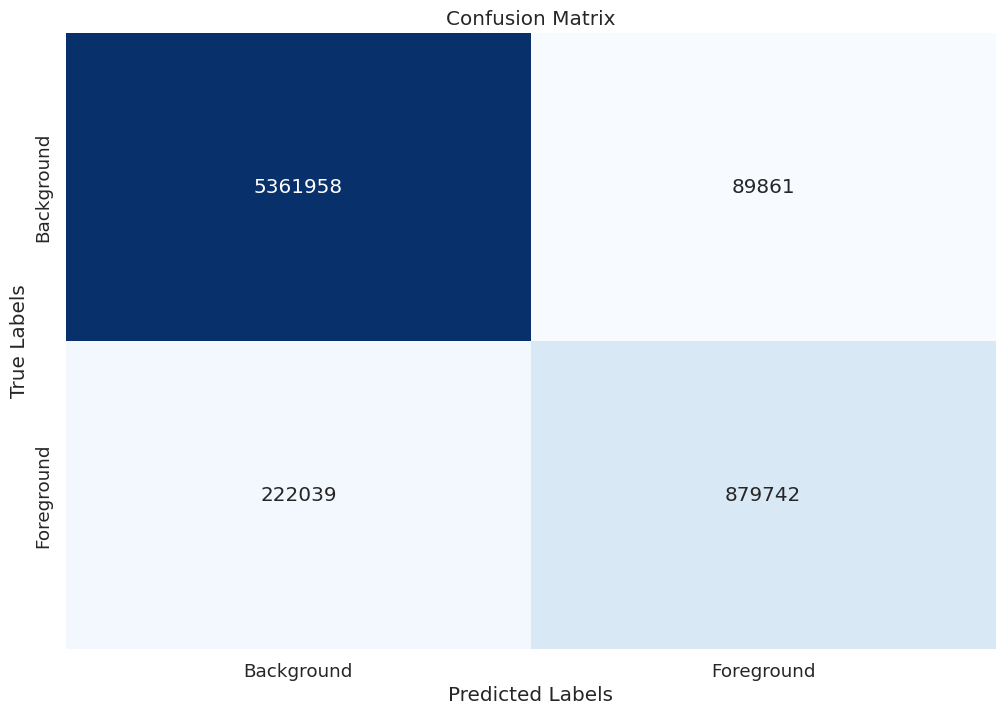

In [ ]:
test_image = test_images_gen[0]
test_mask = test_masks_gen[0]

# Generate predictions for the test image
prediction = loaded_model.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Convert masks to 1D arrays and flatten them
test_mask_flat = test_mask.ravel()
binary_prediction_flat = binary_prediction.ravel()

# Convert binary masks to binary labels (0 or 1)
test_mask_labels = (test_mask_flat > 0).astype(np.uint8)
binary_prediction_labels = (binary_prediction_flat > 0).astype(np.uint8)

# Create the confusion matrix
conf_mat = confusion_matrix(test_mask_labels, binary_prediction_labels)
print(conf_mat)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

<a name="precision-and-recall"></a>
### Precision and Recall

**Precision**, also known as the *Positive Predictive Value (PPV)*, measures the proportion of true positive predictions among all the positive predictions made by the model. In other words, it answers the question: "Of all the instances that the model labeled as positive, how many are actually positive?"

$$
\text{Precision} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP) + False Positive (FP)}}
$$
<br>
Precision is more concerned with the purity of the positive predictions, aiming to **minimize false positives**.

**Recall** score, also known as *Sensitivity* or *true positive rate*, measures the proportion of true positives among all the actual positives. It answers the question: "Of all the actual positive instances, how many did the model correctly identify?"

$$
\text{Recall} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP) + False Negative (FN)}}
$$
<br>
Recall is more concerned with capturing all the possible positive instances, aiming to **minimize false negatives**.

we can use the values from the confusion matrix (TP, TN, FP, and FN) to calculate evaluation metrics such as precision, recall, IoU, and dice coefficient, which provide a comprehensive assessment of the model's segmentation performance.



In [ ]:
class_names = ["Background", "Foreground"]

# Generate the classification report
report = classification_report(test_mask_labels, binary_prediction_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

  Background       0.96      0.98      0.97   5451819
  Foreground       0.91      0.80      0.85   1101781

    accuracy                           0.95   6553600
   macro avg       0.93      0.89      0.91   6553600
weighted avg       0.95      0.95      0.95   6553600



In [ ]:
# Initialize variables to store the total intersection, union, and sums for Dice coefficient
total_intersection = 0
total_union = 0
total_dice_numerator = 0
total_dice_denominator = 0

# Get the total number of samples in the test set
num_samples = len(test_masks_gen)

# Define a function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_numerator = 2.0 * intersection
    dice_denominator = np.sum(y_true) + np.sum(y_pred)
    return dice_numerator, dice_denominator

# Compute Intersection over Union (IoU) and Dice coefficient for each batch in the test set
for i in range(num_samples):
    # Get the next batch of test images and masks
    batch_images = test_images_gen[i]
    batch_masks = test_masks_gen[i]

    # Generate predictions for the batch
    batch_predictions = loaded_model.predict(batch_images, verbose=0)

    # Threshold the predictions to obtain binary masks
    binary_predictions = (batch_predictions > 0.5).astype(np.uint8)

    # Compute intersection and union for the batch
    intersection = np.logical_and(batch_masks, binary_predictions)
    union = np.logical_or(batch_masks, binary_predictions)

    # Compute Dice coefficient for the batch
    dice_numerator, dice_denominator = dice_coefficient(batch_masks, binary_predictions)

    # Update the totals
    total_intersection += np.sum(intersection)
    total_union += np.sum(union)
    total_dice_numerator += dice_numerator
    total_dice_denominator += dice_denominator

# Compute the mean IoU and Dice coefficient across all batches
mean_iou = total_intersection / total_union
mean_dice = total_dice_numerator / total_dice_denominator

# Print the mean IoU and Dice coefficient
print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice Coefficient: {mean_dice}")

Mean IoU: 0.7382603164373193
Mean Dice Coefficient: 0.8566933243478139


<a name="mask-prediction"></a>
### Mask prediction

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Get the corresponding test image and mask (from only 1 batch)
test_image = test_images_gen[0]
test_mask = test_masks_gen[0]

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_model.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()